# OCR 비교

1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?  
기획한 서비스가 OCR 적용 가능한 서비스이며, OCR 기술을 활용했을 때 더 유용한지에 대한 타당성 여부를 기술하였다.  
  
2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?  
앞서 기획한 서비스에서 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시하고, 평가기준에 적합한 테스트 데이터의 특징이 무엇인지 설명하였다.  
  
3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?  
최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.  

데이터셋 준비  
keras-ocr, Tesseract로 테스트 진행
테스트 결과 정리
결과 분석과 결론 제시

In [1]:
import os
import glob

In [2]:
os.getcwd()

'/aiffel/aiffel'

In [3]:
path=os.getenv('HOME')+'/aiffel/ocr_image/*'
file_list= glob.glob(path)
file_list

['/aiffel/aiffel/ocr_image/the_flying.jpg',
 '/aiffel/aiffel/ocr_image/hg.jpg',
 '/aiffel/aiffel/ocr_image/td.jpg',
 '/aiffel/aiffel/ocr_image/sh6.png',
 '/aiffel/aiffel/ocr_image/sh4.png',
 '/aiffel/aiffel/ocr_image/sh1.png',
 '/aiffel/aiffel/ocr_image/sh2.png',
 '/aiffel/aiffel/ocr_image/tp.jpg',
 '/aiffel/aiffel/ocr_image/cp_let.jpg']

### keras_ocr 사용

In [4]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [5]:
images = [ keras_ocr.tools.read(file_name) for file_name in file_list]
prediction_groups = [pipeline.recognize([file_name]) for file_name in file_list]

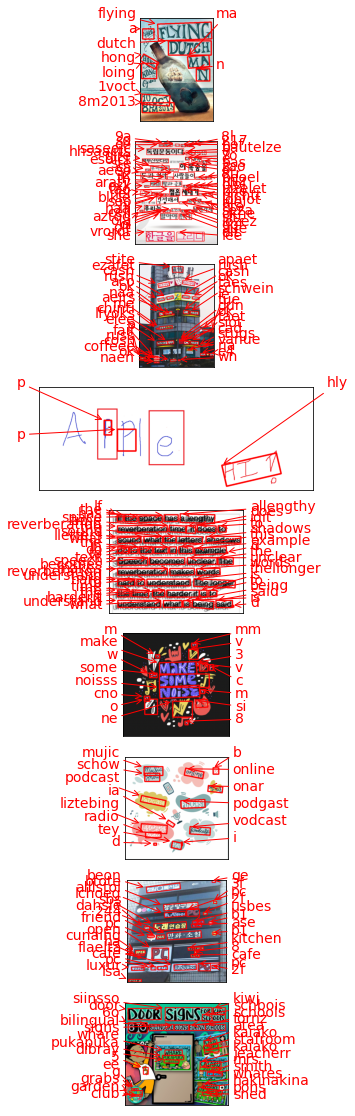

In [6]:
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

한글은 검출만 하고 인식을 못하긴 하지만 나름 잡아낸 것처럼 보였고, 영어(정확히는 영어 문자들)에 대해서는 꽤 잘 잡아내었다.(맨 마지막 그림에 있는 문자는 모두 영어 문자, 알파뱃이지만 영어와 마오리족의 언어가 병기되어 있다.)

### tesseract 사용

In [10]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_image/'
img_file_path = work_dir + '/cp_let.jpg' 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir+'outputs/')

/aiffel/aiffel/ocr_image/outputs/0000.png
/aiffel/aiffel/ocr_image/outputs/0001.png
/aiffel/aiffel/ocr_image/outputs/0002.png
/aiffel/aiffel/ocr_image/outputs/0003.png
/aiffel/aiffel/ocr_image/outputs/0004.png
/aiffel/aiffel/ocr_image/outputs/0005.png
/aiffel/aiffel/ocr_image/outputs/0006.png
/aiffel/aiffel/ocr_image/outputs/0007.png
/aiffel/aiffel/ocr_image/outputs/0008.png
/aiffel/aiffel/ocr_image/outputs/0009.png
/aiffel/aiffel/ocr_image/outputs/0010.png


In [11]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

DOOR


en

BILINGUAL

SIGNS

EOR.NZ

SCHOOLS

. Regt << Rta

SS

Se ee

:

Done
